In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import * 

# IV skew 的统计分析

## 1. IV Skew 的本质  

- **隐含波动率曲线（IV Curve）**：同一到期日、不同执行价的期权，其隐含波动率通常会随着执行价高低而有系统性变化──这就是 IV 曲线。  
- **整体 Skew（Slope）**：把执行价的对数偏离度 $\log(K/S)$（log-moneyness）当自变量，IV 做线性回归，回归斜率即整体 Skew。  
- **局部 Skew（Local Skew 或 Skew per Step）**：用相邻档位的 IV 差分近似导出数值，更聚焦于每个 strike 附近的斜度。

---

## 2. 用 ATM 基准和步长计算 `skew_per_step`  

1. **确定 ATM**  
   - 每分钟（及每个到期日）选出最接近底层价格 $S$ 的执行价 $K_{\rm atm}$，并取其 IV 为 $\text{IV}_{\rm atm}$。  
2. **量化步长**  
   - CF 合约的最小行权价步长是 200 点。  
   - 定义  
     $$
       \Delta_\text{steps} = \frac{K - K_{\rm atm}}{200}
     $$
3. **局部偏度**  
   - 对每一行  
     $$
       \text{skew\_per\_step} \;=\;
       \frac{\text{IV}(K) - \text{IV}_{\rm atm}}{\Delta_\text{steps}}
       \quad(\Delta_\text{steps}\neq0)
     $$
   - ATM 档位 $\Delta_\text{steps}=0$ 时，可将 `skew_per_step` 设为 NaN。

---

## 3. 滚动分位数：捕捉 “异常” Skew  

我们要知道在历史同档位下，这个 `skew_per_step` 正常分布在哪里，然后当前值落在某个极端分位就发信号。

1. **按档位分组**  
   $$
     \text{for each }\;d\in\{\dots,-2,-1,1,2,\dots\}:\;
     X_{d,t} = \bigl\{\text{skew\_per\_step}(t') \mid \Delta_\text{steps}=d,\;t'\le t\}
   $$
2. **滑动窗口**  
   - 用过去 $W$ 条记录（或过往 $D$ 交易日同一分钟点的样本）做窗口。  
   - 窗口大小建议：$W\approx3\text{天}\times240\text{分钟}=720$条，或按分钟数直接定 $W$。  
3. **计算 quantile**  
   - 对每组 $X_{d,t}$ 维护  
     $
       q_{d,t}^{\alpha} = \operatorname{Quantile}\bigl(X_{d,t},\,\alpha\bigr)
     $
   - 常用 $\alpha=0.90,0.95$（做 Put Spread）、$\alpha=0.10,0.05$（做 Call Spread）。
4. **信号触发**  
   - **做多 Put Spread**（捕捉恐慌过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}>q^{0.90}_{d,t}
     $$
   - **做多 Call Spread**（捕捉乐观过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}<q^{0.10}_{d,t}
     $$

---

## 4. 实践要点与优化  

- **最低档位筛选**：一般跳过 $|\Delta_\text{steps}|<2$的档位，过滤流动性差、噪声大的近 ATM 档。  
- **最少样本期**：window 内至少保留 $\min\_periods$个样本（例如 1000 条）再开始计算 quantile，避免极端失真。  
- **平滑处理**：如信号过于抖动，可对 `skew_per_step` 做短窗口（3–5 分钟） rolling mean，再比较分位数。  
- **信号冷却**：一旦同档位触发信号，设置几分钟内不重复进场，防止高频震荡。  
- **止盈止损**：例如 skew 回归至历史中位数（50% 分位）时平仓，或达到固定持有分钟数后强制平仓。  
- **回测验证**：  
  1. 在历史分钟线数据上模拟开／平仓，记录 P&L 曲线、胜率、Sharpe。  
  2. 网格搜索 $\{\alpha\in[0.90,0.95],\,W\in[2000,10000],\,|\Delta_\text{steps}|\ge2\}$ 等参数组合。  

---

### 小结

- **核心指标**：`skew_per_step = (IV - IV_atm)/Δsteps`，反映相对于 ATM 的局部斜度。  
- **信号逻辑**：基于每个档位 `skew_per_step` 的历史滚动分位极值，判断“偏高”或“偏低”再做对应价差。  
- **关键落地**：窗口期 $W$、分位度 $\alpha$、档位筛选、平滑与冷却等参数都需回测验证才能定下来。



## 初始化

In [2]:
path="opt_test_data/OI_options_data.parquet"
size=100
CF=Option_strat(path,size)

In [3]:
df=CF.read_df(path)

In [4]:
df

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T
0,2024-06-03 21:00,OI2407C8700,56.275000,51.200000,550.0,1.0,0.0,True,8700.0,8.0,8581.825000,53.737500,55.0,2024-06-03,2024-06-03 21:00:00,0.031746
1,2024-06-03 21:00,OI2407C8800,30.785714,26.500000,1500.0,5.0,0.0,True,8800.0,8.0,8575.142857,28.642857,30.0,2024-06-03,2024-06-03 21:00:00,0.031746
2,2024-06-03 21:00,OI2407P8400,37.000000,33.500000,4950.0,15.0,2352.0,False,8400.0,8.0,8578.500000,35.250000,33.0,2024-06-03,2024-06-03 21:00:00,0.031746
3,2024-06-03 21:00,OI2407P8500,65.705882,60.500000,630.0,1.0,2365.0,False,8500.0,8.0,8582.382353,63.102941,63.0,2024-06-03,2024-06-03 21:00:00,0.031746
4,2024-06-03 21:00,OI2407P8700,181.437500,171.500000,1720.0,1.0,0.0,False,8700.0,8.0,8578.312500,176.468750,172.0,2024-06-03,2024-06-03 21:00:00,0.031746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551414,2024-08-14 22:59,OI2501P8000,394.833333,326.000000,157375.0,46.0,706.0,False,8000.0,118.0,8004.333333,360.416667,354.0,2024-08-14,2024-08-14 22:59:00,0.468254
551415,2024-08-14 22:59,OI2501P8100,446.500000,381.375000,118320.0,30.0,623.0,False,8100.0,118.0,8004.375000,413.937500,396.0,2024-08-14,2024-08-14 22:59:00,0.468254
551416,2024-08-14 22:59,OI2501P8200,488.000000,261.833333,229725.0,51.0,548.0,False,8200.0,118.0,8007.222222,374.916667,466.0,2024-08-14,2024-08-14 22:59:00,0.468254
551417,2024-08-14 22:59,OI2501P8300,553.000000,322.687500,155220.0,30.0,438.0,False,8300.0,118.0,8007.500000,437.843750,533.0,2024-08-14,2024-08-14 22:59:00,0.468254


### 计算iv

In [5]:
df_iv=CF.add_iv(df)

#### 同一strike，平均化iv

In [6]:
df_iv=CF.ave_iv(df_iv)

In [6]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv
0,2024-06-03 21:00,OI2407C8700,56.275000,51.200000,550.0,1.0,0.0,True,8700.0,8.0,8581.825000,53.737500,55.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.166293
1,2024-06-03 21:00,OI2407C8800,30.785714,26.500000,1500.0,5.0,0.0,True,8800.0,8.0,8575.142857,28.642857,30.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.169872
2,2024-06-03 21:00,OI2407P8400,37.000000,33.500000,4950.0,15.0,2352.0,False,8400.0,8.0,8578.500000,35.250000,33.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.166083
3,2024-06-03 21:00,OI2407P8500,65.705882,60.500000,630.0,1.0,2365.0,False,8500.0,8.0,8582.382353,63.102941,63.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.162878
4,2024-06-03 21:00,OI2407P8700,181.437500,171.500000,1720.0,1.0,0.0,False,8700.0,8.0,8578.312500,176.468750,172.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.170268
5,2024-06-03 21:01,OI2407C8500,141.172414,135.344828,6875.0,5.0,981.0,True,8500.0,8.0,8567.465517,138.258621,137.655172,2024-06-03,2024-06-03 21:01:00,0.031746,0.166445
6,2024-06-03 21:01,OI2407C8700,53.384615,48.153846,1050.0,2.0,0.0,True,8700.0,8.0,8569.269231,50.769231,51.153846,2024-06-03,2024-06-03 21:01:00,0.031746,0.168208
7,2024-06-03 21:01,OI2407C8800,30.425000,27.350000,4390.0,15.0,0.0,True,8800.0,8.0,8569.250000,28.887500,29.062500,2024-06-03,2024-06-03 21:01:00,0.031746,0.173199
8,2024-06-03 21:01,OI2407C9000,10.153846,9.538462,3405.0,34.0,8870.0,True,9000.0,8.0,8566.615385,9.846154,10.000000,2024-06-03,2024-06-03 21:01:00,0.031746,0.191212
9,2024-06-03 21:01,OI2407P7900,3.000000,2.500000,1025.0,41.0,1408.0,False,7900.0,8.0,8567.166667,2.750000,2.500000,2024-06-03,2024-06-03 21:01:00,0.031746,0.226480


In [7]:
df_iv=CF.get_underly_F(df_iv)

In [8]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv,underly_F
0,2024-06-03 21:00,OI2407C8700,56.275000,51.200000,550.0,1.0,0.0,True,8700.0,8.0,8581.825000,53.737500,55.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.166293,8578
1,2024-06-03 21:00,OI2407C8800,30.785714,26.500000,1500.0,5.0,0.0,True,8800.0,8.0,8575.142857,28.642857,30.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.169872,8578
2,2024-06-03 21:00,OI2407P8400,37.000000,33.500000,4950.0,15.0,2352.0,False,8400.0,8.0,8578.500000,35.250000,33.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.166083,8580
3,2024-06-03 21:00,OI2407P8500,65.705882,60.500000,630.0,1.0,2365.0,False,8500.0,8.0,8582.382353,63.102941,63.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.162878,8580
4,2024-06-03 21:00,OI2407P8700,181.437500,171.500000,1720.0,1.0,0.0,False,8700.0,8.0,8578.312500,176.468750,172.000000,2024-06-03,2024-06-03 21:00:00,0.031746,0.170268,8580
5,2024-06-03 21:01,OI2407C8500,141.172414,135.344828,6875.0,5.0,981.0,True,8500.0,8.0,8567.465517,138.258621,137.655172,2024-06-03,2024-06-03 21:01:00,0.031746,0.166445,8568
6,2024-06-03 21:01,OI2407C8700,53.384615,48.153846,1050.0,2.0,0.0,True,8700.0,8.0,8569.269231,50.769231,51.153846,2024-06-03,2024-06-03 21:01:00,0.031746,0.168208,8568
7,2024-06-03 21:01,OI2407C8800,30.425000,27.350000,4390.0,15.0,0.0,True,8800.0,8.0,8569.250000,28.887500,29.062500,2024-06-03,2024-06-03 21:01:00,0.031746,0.173199,8568
8,2024-06-03 21:01,OI2407C9000,10.153846,9.538462,3405.0,34.0,8870.0,True,9000.0,8.0,8566.615385,9.846154,10.000000,2024-06-03,2024-06-03 21:01:00,0.031746,0.191212,8568
9,2024-06-03 21:01,OI2407P7900,3.000000,2.500000,1025.0,41.0,1408.0,False,7900.0,8.0,8567.166667,2.750000,2.500000,2024-06-03,2024-06-03 21:01:00,0.031746,0.226480,8568


### 确定ATM strike，计算local skew

* 选择ATM iv，根据200的价差去计算skew，这样统计分位数，也方便去交易。

* 其实到了这一步，可以去构建vol surface，看是否有 non-convex 套利的机会

In [9]:
df_skew=CF.get_local_skew(df_iv)

In [10]:
df_skew

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,...,twap,date_str,minute,T,iv,underly_F,strike_atm,iv_atm,strike_diff_steps,skew_per_step
0,2024-06-03 21:00,OI2407P8400,37.000000,33.5,4950.0,15.0,2352.0,False,8400.0,8.0,...,33.0,2024-06-03,2024-06-03 21:00:00,0.031746,0.166083,8580,8500.0,0.162878,-1,-0.003205
1,2024-06-03 21:00,OI2407P8500,65.705882,60.5,630.0,1.0,2365.0,False,8500.0,8.0,...,63.0,2024-06-03,2024-06-03 21:00:00,0.031746,0.162878,8580,8500.0,0.162878,0,NaN
2,2024-06-03 21:00,OI2407C8700,56.275000,51.2,550.0,1.0,0.0,True,8700.0,8.0,...,55.0,2024-06-03,2024-06-03 21:00:00,0.031746,0.166293,8578,8500.0,0.162878,2,0.001708
3,2024-06-03 21:00,OI2407P8700,181.437500,171.5,1720.0,1.0,0.0,False,8700.0,8.0,...,172.0,2024-06-03,2024-06-03 21:00:00,0.031746,0.170268,8580,8500.0,0.162878,2,0.003695
4,2024-06-03 21:00,OI2407C8800,30.785714,26.5,1500.0,5.0,0.0,True,8800.0,8.0,...,30.0,2024-06-03,2024-06-03 21:00:00,0.031746,0.169872,8578,8500.0,0.162878,3,0.002331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551414,2024-08-14 22:59,OI2501C9600,122.500000,18.0,865.0,2.0,233.0,True,9600.0,118.0,...,42.5,2024-08-14,2024-08-14 22:59:00,0.468254,0.217779,8005,8000.0,0.168037,16,0.003109
551415,2024-08-14 22:59,OI2501C9700,116.000000,12.0,11640.0,32.0,221.0,True,9700.0,118.0,...,38.0,2024-08-14,2024-08-14 22:59:00,0.468254,0.220569,8005,8000.0,0.168037,17,0.003090
551416,2024-08-14 22:59,OI2501C9800,108.000000,22.5,405.0,1.0,125.0,True,9800.0,118.0,...,40.5,2024-08-14,2024-08-14 22:59:00,0.468254,0.229995,8005,8000.0,0.168037,18,0.003442
551417,2024-08-14 22:59,OI2501C9900,108.000000,19.5,395.0,1.0,120.0,True,9900.0,118.0,...,39.5,2024-08-14,2024-08-14 22:59:00,0.468254,0.236629,8005,8000.0,0.168037,19,0.003610


#### ATM iv 可视化


In [11]:
atm_iv=CF.get_atm_iv(df_skew)

<Axes: xlabel='minute'>

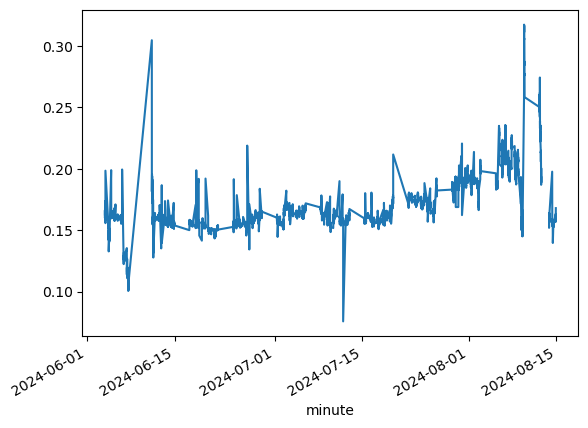

In [12]:
atm_iv.iv_atm.plot()

**ATM IV trading**:

* 第一，检测并确认是否需要过滤掉outliers。
* 第二，可以直接计算rolling quantile交易ATM IV。
* 第三，可以对ATM IV运用时间序列分析或者预测，比如 LSTM，去预测IV。

不过此次分析不在此方向展开，主要研究local skew。

#### 可视化skew统计性质

* 确定是否有均值回归现象。
* 确定哪些diff step 存在比较明显的均值回归。
* 确定均值回归的平均时间（半衰期）。

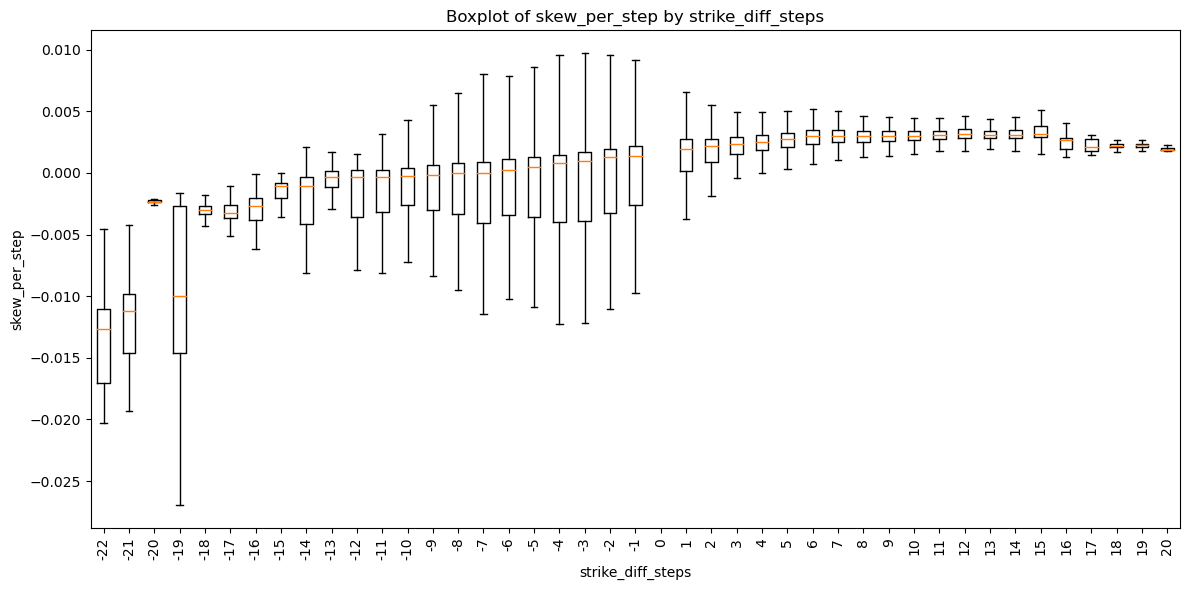

In [13]:
CF.plot_box(df_skew)

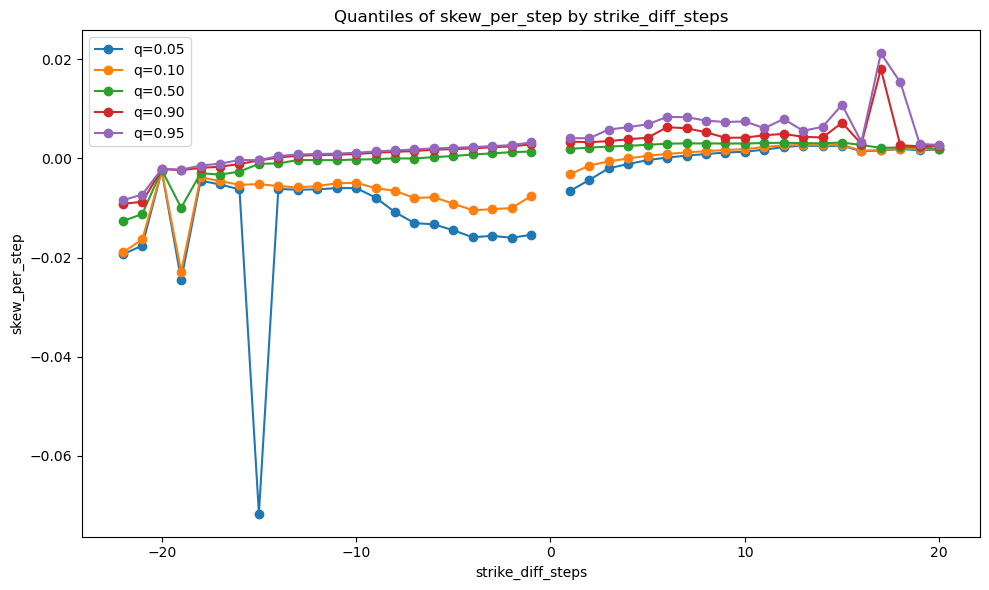

In [14]:
CF.plot_quantile(df_skew)

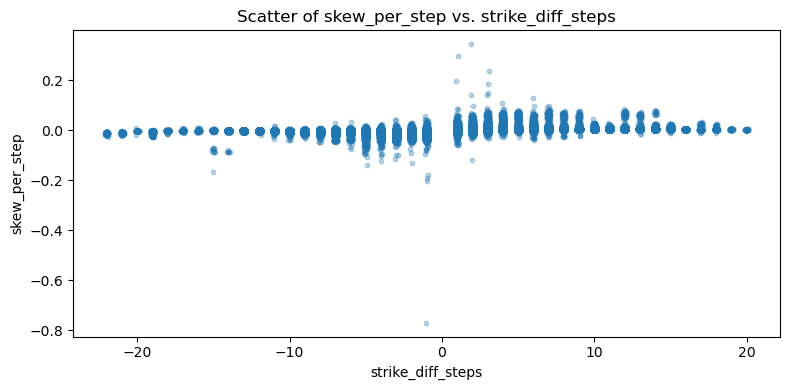

In [15]:
CF.plot_scatter(df_skew)

In [16]:
CF_sig=Signals([0.1,0.9])

In [17]:
events_df=CF_sig.get_signals(df_skew)

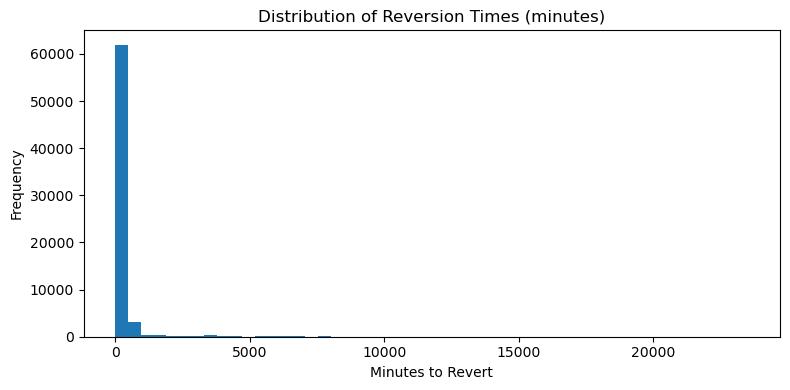

<Figure size 1000x400 with 0 Axes>

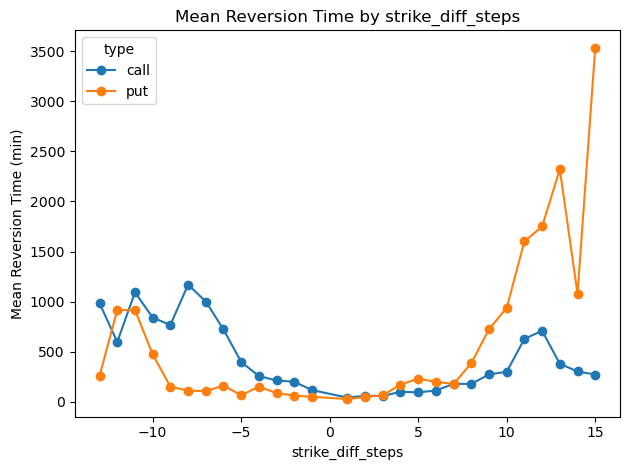

Overall mean reversion times (min):
type
call    227.231289
put     189.585959
Name: dt, dtype: float64


In [18]:
events_df,agg=CF_sig.plot(events_df)

In [19]:
agg

type,call,put
steps,,
-13,984.142857,261.000000
-12,598.454545,916.800000
-11,1093.586592,916.256757
-10,841.648464,473.756198
-9,767.224199,152.535849
-8,1170.417997,112.187204
-7,1001.716667,107.719895
-6,723.110899,163.002169
-5,398.458667,66.272476


#### 结论

* 选择step size 从-5，到10.
* 选择qunatile0.05和0.95作为入场信号，quantile 0.5 作为平仓信号。

### 回测

In [20]:
df = df_skew.sort_values(['strike_diff_steps', 'minute']).reset_index(drop=True)


In [21]:
CF.bact_test(df)

总笔数： 14017
总 PnL： -215767.4831957953
平均单笔 PnL： -15.393271256031626
胜率： 0.0434472426339445
      count       mean            sum        std
type                                            
call   9860 -10.825759 -106741.985685  38.046395
put    4157 -26.226966 -109025.497510  48.668369
       count       mean
steps                  
-1      2647 -17.763536
 2      3575 -14.006927
 3      2769 -18.467649
 4      2201 -11.443968
 5      1472 -11.792567
 6       876 -16.465745
 7       477 -22.148620


提高quantile阈值，减少交易频率。

In [22]:
CF.bact_test(df_skew.sort_values(['strike_diff_steps', 'minute']).reset_index(drop=True),quantile=[0.02,0.98])

总笔数： 6848
总 PnL： -132697.72441690508
平均单笔 PnL： -19.37758826181441
胜率： 0.06089369158878505
      count       mean           sum        std
type                                           
call   5018 -12.756089 -64010.055576  45.191121
put    1830 -37.534245 -68687.668841  63.729811
       count       mean
steps                  
-1      1137 -26.711855
 2      1705 -17.441536
 3      1390 -23.315137
 4      1092 -14.235193
 5       796 -13.352862
 6       469 -11.863791
 7       259 -32.597141


结论分析：

稳定亏损，可能存在的原因。

* 直接take ask-bid spread，两次，spread过大会直接吃掉潜在的收益。
* 未考虑持仓时间，theta上亏钱。
* 平仓线太粗糙了，应该设计分批入仓、分批出场以及止损。
* 分钟线上，交易频率太高。考虑5min重新设计策略。